# Probabilistic Count Matrix Factorization on real scRNA-seq data

We want to find a way of expressing the assumption that dropout rates are linked with library size. To do this, we infer the parameters of a pCMF on a real scRNA-seq data set and check if there are any properties in V or in U that can be exploited.

In [16]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, cavi, svi_new
import plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pandas as pd
from scipy.stats import gamma

plt.style.use('ggplot')

# Data loading

In [2]:
brain_tags = pd.read_csv('../../Datasets/scRNA-seq/reference_data/CIDR/CIDR-examples/Brain/brainTags.csv')

In [3]:
brain_tags = brain_tags.drop('Unnamed: 0', axis=1)

In [4]:
info = pd.read_csv('../../Datasets/scRNA-seq/reference_data/CIDR/CIDR-examples/Brain/SraRunTable.txt', sep='\t')

In [5]:
mapping = [list(info.Sample_Name_s).index(cell_name) if cell_name in list(info.Sample_Name_s) else None for cell_name in list(brain_tags.columns)]

In [6]:
cell_type = info.cell_type_s[mapping]

In [7]:
types = cell_type.unique()

In [8]:
## Assign each cell a color according to its type
scols = ["red","blue","green","brown","pink","purple","darkgreen","grey"]
cols = []
for i in range(len(cell_type)):
    cols.append(scols[np.argwhere(list(cell_type)[i]==types)[0][0]])

In [9]:
cell_type[cell_type == types[0]] = "fetal quiescent"
cell_type[cell_type == types[1]] = "fetal replicating"
#cell_type[cell_type == types[-1]] = "oligodendrocyte precursor cells"

In [10]:
# Change to clearer cell type names
types[0] = "fetal quiescent"
types[1] = "fetal replicating"
#types[-1] = "oligodendrocyte precursor cells"

In [11]:
prior_tpm = 1
brain_10 = brain_tags[np.sum(brain_tags, axis=1) > 10]  # remove genes with zero expression across all cells
brain_10_lcpm = np.log2(brain_10 / np.sum(brain_10, axis=0) * 1000000 + prior_tpm) # log (counts per million + 1)

In [12]:
brain_10.shape

(18565, 420)

In [13]:
types

array(['fetal quiescent', 'fetal replicating', 'astrocytes', 'neurons',
       'endothelial', 'oligodendrocytes', 'microglia', 'OPC'],
      dtype=object)

In [14]:
Y = brain_10.T.as_matrix()

In [22]:
# Experiment parameters
N = Y.shape[0] # number of observations
P = Y.shape[1] # observation space dimensionality
K = 2 # latent space dimensionality
C = types.size # number of clusters

# Run PCA
pca_U = PCA(n_components=2).fit_transform(np.log(Y + 1))

# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
mb = 100
print('SVI w/ minibatch size = %d:' % mb)
inf = svi_new.StochasticVI(Y, alpha, beta, pi)
svi_ll = inf.run_svi(n_iterations=40, minibatch_size=mb, return_ll=False, sampling_rate=1., max_time=60.)
svi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

# print('\n')

# # Run CAVI and get estimates (pCMF)
# alpha = np.ones((2, K))
# alpha[0, :] = 3.
# alpha[1, :] = 0.5
# beta = np.ones((2, P, K))
# pi = np.ones((P,)) * 0.5
# print('CAVI:')
# inf = cavi.CoordinateAscentVI(Y, alpha, beta, pi)
# cavi_ll = inf.run_cavi(n_iterations=40, return_ll=False, sampling_rate=1., max_time=60.)
# cavi_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation

SVI w/ minibatch size = 100:


KeyboardInterrupt: 

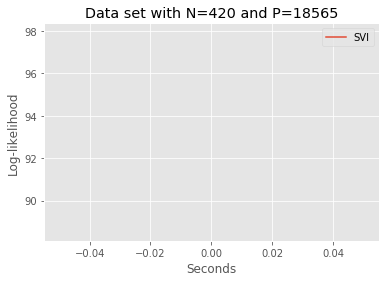

In [18]:
plt.plot(svi_ll[1], label='SVI')
plt.ylabel('Log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

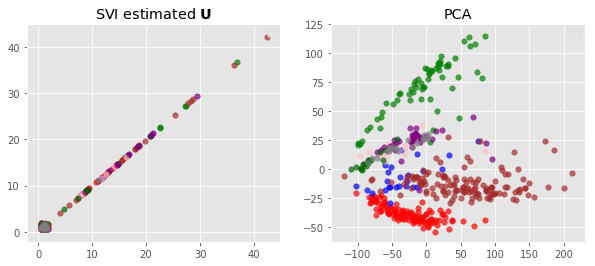

In [19]:
# Plot lower-dimensional embeddings
s = 30
alpha = 0.7
labels=[]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
handlers = []
for i in range(types.size):
    h = ax1.scatter(svi_U[cell_type==types[i], 0], svi_U[cell_type==types[i], 1], c=scols[i], 
                label=types[i], s=30, alpha=0.7)
    handlers.append(h)
ax1.legend(handlers, labels, scatterpoints=1)
plt.title('SVI estimated $\mathbf{U}$')

ax2 = plt.subplot(1, 2, 2)
handlers = []
for i in range(types.size):
    h = ax2.scatter(pca_U[cell_type==types[i], 0], pca_U[cell_type==types[i], 1], c=scols[i], 
                label=types[i], s=30, alpha=0.7)
    handlers.append(h)
ax2.legend(handlers, labels, scatterpoints=1)
plt.title('PCA')

plt.show()

In [21]:
svi_silh = silhouette_score(svi_U, cell_type)
pca_silh = silhouette_score(pca_U, cell_type)

scores = {'PCA': pca_silh, 'SVI': svi_silh}
max_key = max(scores, key=scores.get)

print('Silhouette scores (higher is better):')
for key in scores:
    if key == max_key: print('\033[1m', end="")
    print('- ' + key + ': %0.3f' % scores[key] + '\033[0m')

Silhouette scores (higher is better):
- PCA: 0.084
- SVI: -0.533
